In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import PIL
import io
import html
import time

In [28]:
with_mask = np.load('/content/drive/MyDrive/Colab Notebooks/FaceMask/Dataset/with_mask.npy')

In [29]:
without_mask = np.load('/content/drive/MyDrive/Colab Notebooks/FaceMask/Dataset/without_mask.pickle.npy',encoding='latin1',allow_pickle=True)

In [30]:
with_mask.shape

(25, 50, 50, 3)

In [31]:
without_mask.shape

(25, 50, 50, 3)

In [32]:
with_mask = with_mask.reshape(25,50 * 50 * 3)
without_mask = without_mask.reshape(25,50 * 50 * 3)

In [33]:
with_mask.shape

(25, 7500)

In [34]:
without_mask.shape

(25, 7500)

In [35]:
X = np.r_[with_mask, without_mask]

In [36]:
X.shape

(50, 7500)

In [37]:
labels = np.zeros(X.shape[0])

In [38]:
labels[25:] = 1.0

In [53]:
names = {0 : 'Mask', 1 : 'No Mask'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [40]:
# svm - Support Vectior Machine 
# SVC - Support Vector Classification

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X,labels, test_size = 0.25)

In [28]:
x_train.shape

(37, 7500)

In [42]:
# PCA - Principal Component Analysis
from sklearn.decomposition import PCA

In [43]:
pca = PCA(n_components = 3)
x_train = pca.fit_transform(x_train)

In [28]:
x_train[0]

array([  737.68821137, -2788.33456623,  -152.48157042])

In [23]:
x_train.shape

(45, 7500)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X,labels, test_size = 0.10)

In [45]:
svm = SVC()
svm.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [46]:
# x_test = pca.transform(x_test)
y_pred = svm.predict(x_test)

In [47]:
accuracy_score(y_test, y_pred)

0.8

In [48]:
haar_data = cv2.CascadeClassifier("/content/drive/MyDrive/Colab Notebooks/FaceMask/haarcascade_frontalface_default.xml")

In [49]:
 def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [50]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

<IPython.core.display.Javascript object>

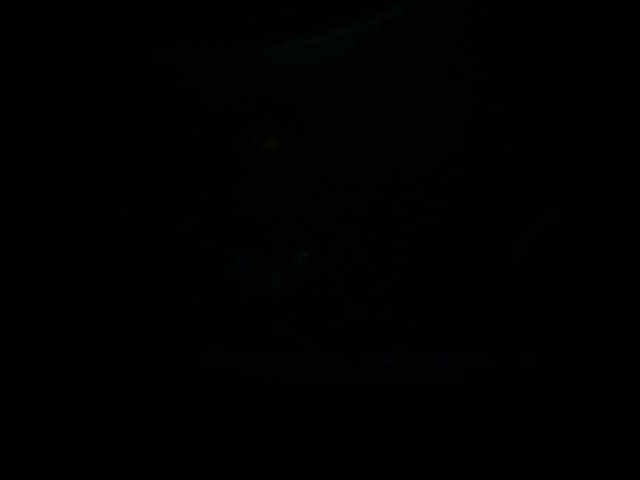

No Mask


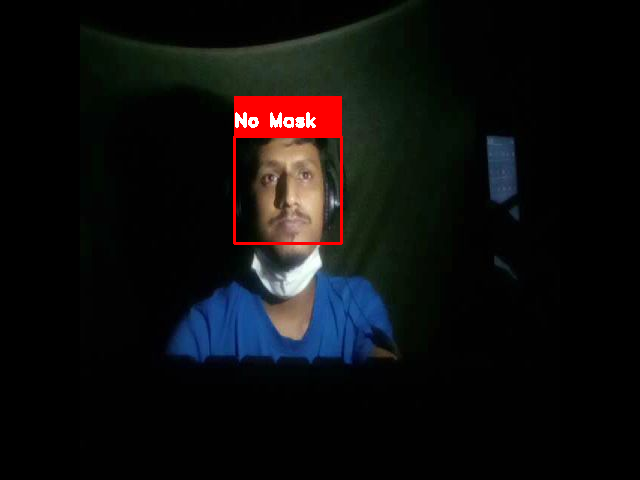

No Mask


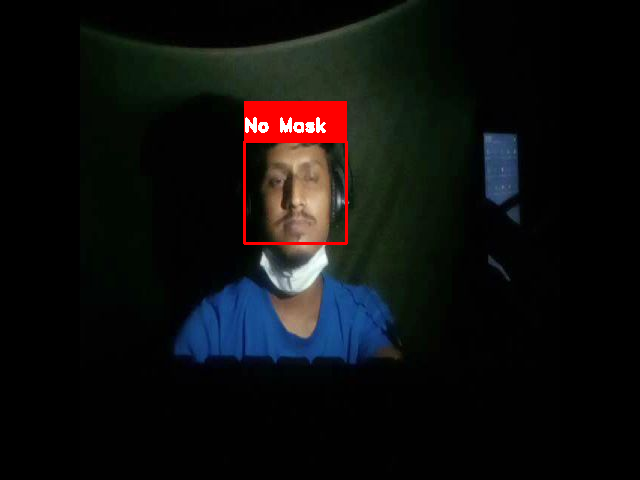

No Mask


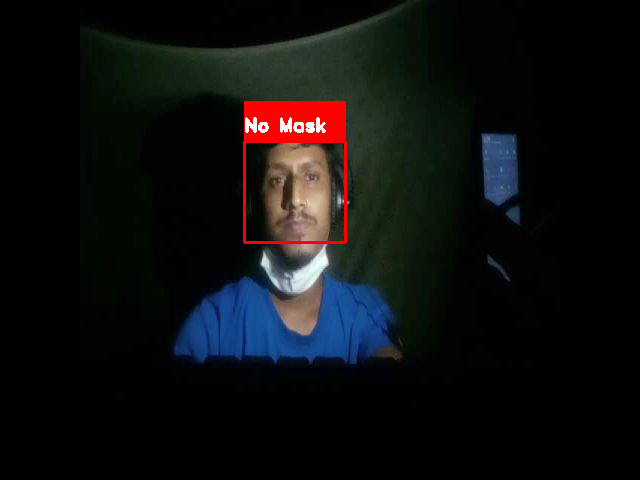

No Mask


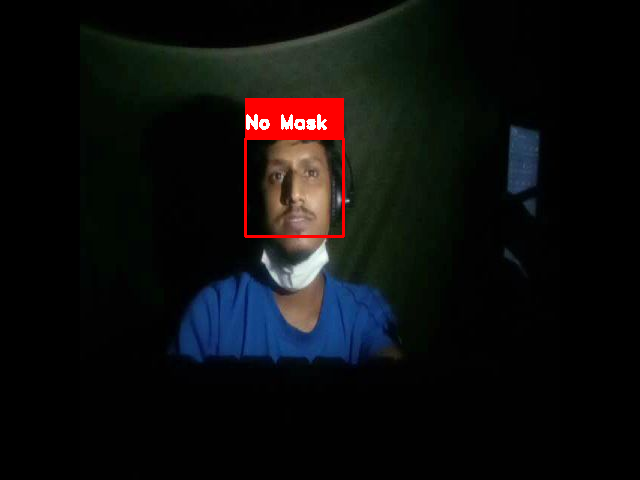

Mask


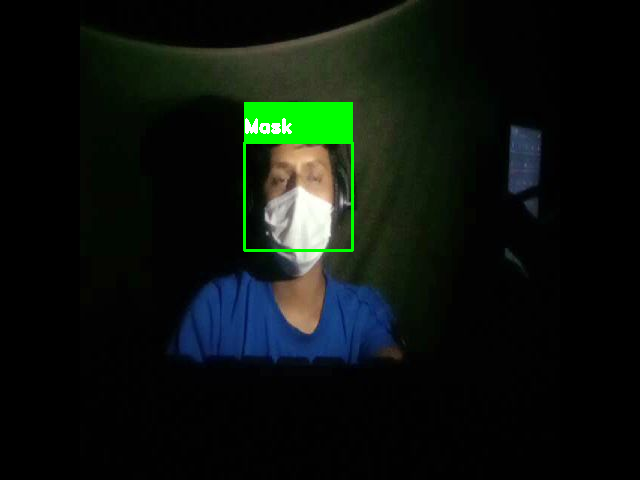

Mask


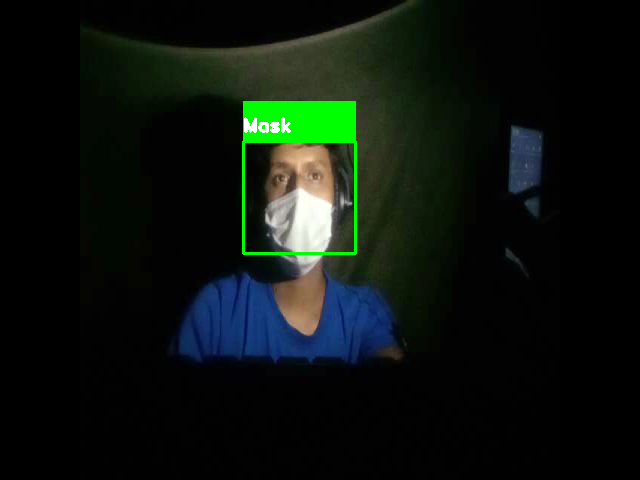

No Mask
Mask


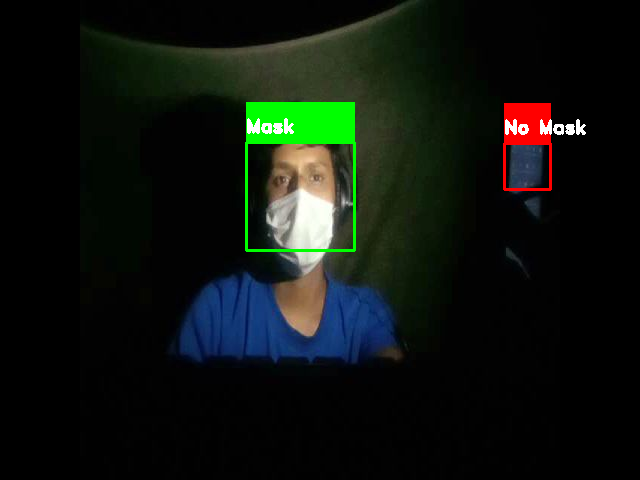

In [52]:
# start streaming video from webcam
video_stream()
font = cv2.FONT_HERSHEY_DUPLEX
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
rect_size = 4
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    # gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = haar_data.detectMultiScale(img)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
        bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
        face = img[y:y+h, x:x+w, : ]
        face = cv2.resize(face,(50,50))
        face = face.reshape(1, -1)
        # face = pca.transform(face)

         
        label=np.argmax(face,axis=1)[0]
      
        pred = svm.predict(face)[0]
        n = names[int(pred)]
        print(n)
        color = color_dict[int(pred)]
        cv2.rectangle(img,(x,y),(x+w,y+h),color,2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color,-1)
        cv2.putText(img, n, (x, y-10),font,0.6,(255,255,255),2)
        

    cv2_imshow(img) 
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes